In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Driving Data

/content/drive/MyDrive/Driving Data


In [ ]:
import pandas as pd

# Load the eye tracker data from XLSX
eye_tracker_data = pd.read_excel('srija_t.xlsx')

# Load the Python logger data from CSV
python_logger_data = pd.read_csv('car_inputs_2.csv')

# Get the start time from the Python logger data
python_start_time = python_logger_data['timestamp'].min()
print(python_start_time, "timestamp")

# Convert 'system time' from microseconds to Unix timestamp
eye_tracker_data['system_time_unix'] = eye_tracker_data['system time'] // 1000000

# Find the 'Experiment Starts' message time in the eye tracker data
experiment_starts_time = eye_tracker_data[eye_tracker_data['message'] == 'Experiment Starts']['system_time_unix'].max()
print(experiment_starts_time, "Experiment Start Time")

# Find the last click event time after 500ms from the 'Experiment Starts' message
eye_tracker_last_click_mask = (eye_tracker_data['message'].str.contains('mouse click')) & (eye_tracker_data['system_time_unix'] > experiment_starts_time + 0.5)
if eye_tracker_last_click_mask.any():
    eye_tracker_last_click_time = eye_tracker_data[eye_tracker_last_click_mask]['system_time_unix'].max()
    print(eye_tracker_last_click_time, "Experiment Last Click Time")
else:
    print("Last click event after 500ms from 'Experiment Starts' not found in the eye tracker data.")

1714158426.9526284 timestamp
40196 Experiment Start Time
40567 Experiment Last Click Time


In [ ]:
import pandas as pd

# Load the eye tracker data from XLSX
eye_tracker_data = pd.read_excel('srija_t.xlsx')

# Load the Python logger data from CSV
python_logger_data = pd.read_csv('car_inputs_2.csv')

# Get the start time from the Python logger data
python_start_time = python_logger_data['timestamp'].min()
print(python_start_time, "timestamp")

# Convert 'system time' from microseconds to Unix timestamp
eye_tracker_data['system_time_unix'] = eye_tracker_data['system time'] // 1000000

# Find the 'Experiment Starts' message time in the eye tracker data
experiment_starts_time = eye_tracker_data[eye_tracker_data['message'] == 'Experiment Starts']['system_time_unix'].max()
print(experiment_starts_time, "Experiment Start Time")

# Find the last click event time after 500ms from the 'Experiment Starts' message
# Find the 'Experiment Starts' message time in the eye tracker data
experiment_starts_time = eye_tracker_data[eye_tracker_data['message'] == 'Experiment Starts']['system_time_unix'].max()
print(experiment_starts_time, "Experiment Start Time")

# Find the first click event time after 500ms from the 'Experiment Starts' message
eye_tracker_last_click_mask = (eye_tracker_data['message'].str.contains('mouse click')) & (eye_tracker_data['system_time_unix'] > experiment_starts_time + 0.5)
if eye_tracker_last_click_mask.any():
    eye_tracker_last_click_time = eye_tracker_data[eye_tracker_last_click_mask]['system_time_unix'].min()
    print(eye_tracker_last_click_time, "Experiment Last Click Time")

    # Find the index of the first mouse click event after 500ms from the 'Experiment Starts' message
    last_click_index = eye_tracker_data[eye_tracker_last_click_mask].index[0]
    next_row_index = last_click_index + 1
    print("last:", last_click_index, "next", next_row_index)

    # Insert the Python logger start time for the row after the last click event
    eye_tracker_data.loc[next_row_index, 'synchronized_timestamp'] = python_start_time

    # eye_tracker_data.to_excel('synchronized_eye_tracker_data.xlsx', index=False)
    print("Timestamps synchronized successfully.")
    print("Synchronized data saved to 'synchronized_eye_tracker_data.xlsx'.")
else:
    print("Last click event after 500ms from 'Experiment Starts' not found in the eye tracker data.")

# Calculate the time difference between each eye tracker timestamp and the last click event time
eye_tracker_data['time_diff'] = eye_tracker_data['divice time'] - eye_tracker_last_click_time

# Add the time difference to python_start_time to get the synchronized Unix timestamp
eye_tracker_data['synchronized_timestamp'] = eye_tracker_data['time_diff'] + python_start_time

# Convert the synchronized Unix timestamp to a readable format (optional)
eye_tracker_data['synchronized_time'] = pd.to_datetime(eye_tracker_data['synchronized_timestamp'], unit='s')

# Save the updated eye tracker data to a new file
eye_tracker_data.to_csv('synchronized_eye_tracker_data.csv', index=False)

# Synchronize the data
first_timestamp = python_logger_data['timestamp'].min()
last_timestamp = python_logger_data['timestamp'].max()
eye_tracker_data = eye_tracker_data[(eye_tracker_data['synchronized_timestamp'] >= first_timestamp) &
                                    (eye_tracker_data['synchronized_timestamp'] <= last_timestamp)]

# Handle missing data
python_logger_data.fillna(0, inplace=True)  # Fill missing values with 0 (adjust as needed)
eye_tracker_data.interpolate(inplace=True)  # Interpolate missing values (adjust as needed)

# Merge the data
merged_data = pd.merge(python_logger_data, eye_tracker_data, left_on='timestamp', right_on='synchronized_timestamp', how='outer')

# Perform additional cleaning and preprocessing
merged_data.drop_duplicates(inplace=True)  # Remove duplicate rows
merged_data['event_type'] = merged_data['event_type'].astype('category')  # Convert event_type to categorical

# Save the cleaned data
merged_data.to_csv('cleaned_data.csv', index=False)

1714158426.9526284 timestamp
40196 Experiment Start Time
40196 Experiment Start Time
40199 Experiment Last Click Time
last: 501 next 502
Timestamps synchronized successfully.
Synchronized data saved to 'synchronized_eye_tracker_data.xlsx'.


In [ ]:
import pandas as pd

# Load the eye tracker data from XLSX
eye_tracker_data = pd.read_excel('srija_t.xlsx')

# Load the Python logger data from CSV
python_logger_data = pd.read_csv('car_inputs_2.csv')

# Get the start time from the Python logger data
python_start_time = python_logger_data['timestamp'].min()
print(python_start_time, "timestamp")

# Find the 'started' message in the eye tracker data
started_mask = eye_tracker_data['message'] == 'started'
if started_mask.any():
    started_index = eye_tracker_data[started_mask].index[0]
    print("Started index:", started_index)

    # Set the synchronized timestamp for the 'started' message
    eye_tracker_data.loc[started_index, 'synchronized_timestamp'] = python_start_time

    # Calculate the synchronized timestamps for subsequent cells
    for i in range(started_index + 1, len(eye_tracker_data)):
        time_diff = (eye_tracker_data.loc[i, 'system time'] - eye_tracker_data.loc[i-1, 'system time']) / 1000000
        eye_tracker_data.loc[i, 'synchronized_timestamp'] = eye_tracker_data.loc[i-1, 'synchronized_timestamp'] + time_diff

    # Update the synchronized timestamp for rows before the 'started' message
    eye_tracker_data.loc[:started_index-1, 'synchronized_timestamp'] = eye_tracker_data.loc[:started_index-1, 'system time'] / 1000000

    # Convert the synchronized timestamp to datetime format
    eye_tracker_data['synchronized_time'] = pd.to_datetime(eye_tracker_data['synchronized_timestamp'], unit='s')

    # Save the updated eye tracker data to a new Excel file
    eye_tracker_data.to_excel('synchronized_eye_tracker_data.xlsx', index=False)

    print("Timestamps synchronized successfully.")
    # print("Synchronized data saved to 'synchronized_eye_tracker_data.xlsx'.")
else:
    print("'started' message not found in the eye tracker data.")


first_timestamp = python_logger_data['timestamp'].min()
last_timestamp = python_logger_data['timestamp'].max()
eye_tracker_data = eye_tracker_data[(eye_tracker_data['synchronized_timestamp'] >= first_timestamp) &
                                    (eye_tracker_data['synchronized_timestamp'] <= last_timestamp)]

# Handle missing data
python_logger_data.fillna(0, inplace=True)  # Fill missing values with 0 (adjust as needed)
eye_tracker_data.interpolate(inplace=True)  # Interpolate missing values (adjust as needed)

# Merge the data
merged_data = pd.merge(python_logger_data, eye_tracker_data, left_on='timestamp', right_on='synchronized_timestamp', how='outer')

# Perform additional cleaning and preprocessing
merged_data.drop_duplicates(inplace=True)  # Remove duplicate rows
merged_data['event_type'] = merged_data['event_type'].astype('category')  # Convert event_type to categorical

# Save the cleaned data
merged_data.to_csv('cleaned_data.csv', index=False)

1714158426.9526284 timestamp
Started index: 588
Timestamps synchronized successfully.


In [ ]:
import pandas as pd

# Load the eye tracker data from XLSX
eye_tracker_data = pd.read_excel('srija_t.xlsx')

# Load the Python logger data from CSV
python_logger_data = pd.read_csv('car_inputs_2.csv')

# Get the start time from the Python logger data
python_start_time = python_logger_data['timestamp'].min()
print(python_start_time, "timestamp")

# Find the 'started' message in the eye tracker data
started_mask = eye_tracker_data['message'] == 'started'
if started_mask.any():
    started_index = eye_tracker_data[started_mask].index[0]
    print("Started index:", started_index)

    # Set the synchronized timestamp for the 'started' message
    eye_tracker_data.loc[started_index, 'synchronized_timestamp'] = python_start_time

    # Calculate the synchronized timestamps for subsequent cells
    for i in range(started_index + 1, len(eye_tracker_data)):
        time_diff = (eye_tracker_data.loc[i, 'system time'] - eye_tracker_data.loc[i-1, 'system time']) / 1000000
        eye_tracker_data.loc[i, 'synchronized_timestamp'] = eye_tracker_data.loc[i-1, 'synchronized_timestamp'] + time_diff

    # Update the synchronized timestamp for rows before the 'started' message
    eye_tracker_data.loc[:started_index-1, 'synchronized_timestamp'] = eye_tracker_data.loc[:started_index-1, 'system time'] / 1000000

    # Convert the synchronized timestamp to datetime format
    eye_tracker_data['synchronized_time'] = pd.to_datetime(eye_tracker_data['synchronized_timestamp'], unit='s')

    # Save the synchronized eye tracker data to a new file
    eye_tracker_data.to_excel('synchronized_eye_tracker_data.xlsx', index=False)
    print("Synchronized eye tracker data saved to 'synchronized_eye_tracker_data.xlsx'.")
else:
    print("'started' message not found in the eye tracker data.")

# Clean and preprocess the Python logger data
python_logger_data.fillna(0, inplace=True)  # Fill missing values with 0 (adjust as needed)
python_logger_data['event_type'] = python_logger_data['event_type'].astype('category')  # Convert event_type to categorical

# Save the cleaned Python logger data to a new file
python_logger_data.to_csv('cleaned_python_logger_data.csv', index=False)
print("Cleaned Python logger data saved to 'cleaned_python_logger_data.csv'.")

1714158426.9526284 timestamp
Started index: 588
Synchronized eye tracker data saved to 'synchronized_eye_tracker_data.xlsx'.
Cleaned Python logger data saved to 'cleaned_python_logger_data.csv'.


Analysis Part

Average left pupil diameter during instruction: 3.151506738243268
Average right pupil diameter during instruction: 3.544345211703678
Average left pupil diameter during user_response: 3.173720881144206
Average right pupil diameter during user_response: 3.63943314980517
Average left pupil diameter during button_press: 3.2167476696254775
Average right pupil diameter during button_press: 3.694334248317556


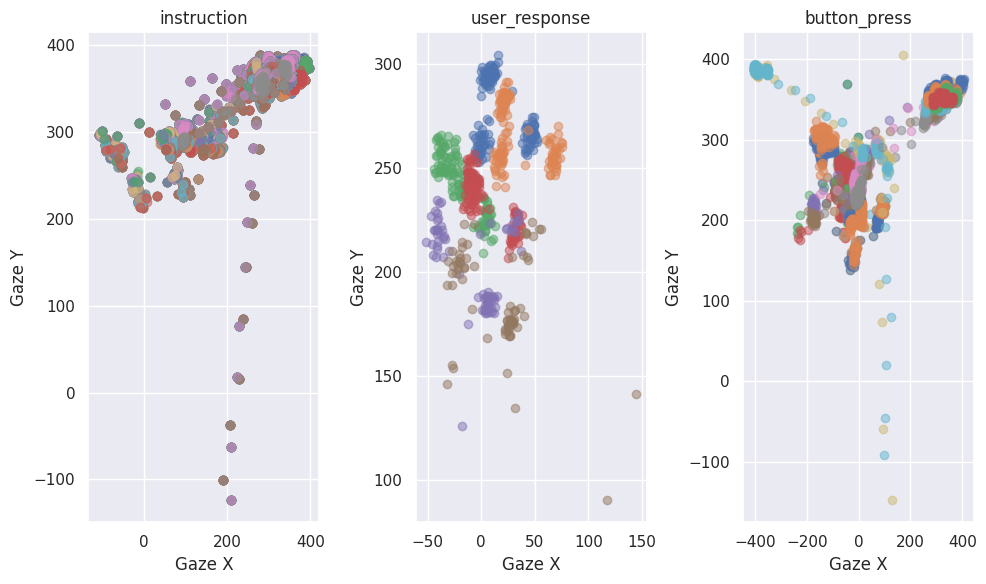

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')

# Identify events of interest
events_of_interest = ['instruction', 'user_response', 'button_press']

# Extract event timestamps
event_timestamps = {}
for event in events_of_interest:
    event_timestamps[event] = python_logger_data[python_logger_data['event_type'] == event]['timestamp'].tolist()

# print(event_timestamps, "event_timestamps")

# Align events with eye tracker data
aligned_data = {}
for event in events_of_interest:
    aligned_data[event] = []
    for timestamp in event_timestamps[event]:
        gaze_data = eye_tracker_data[(eye_tracker_data['synchronized_timestamp'] >= timestamp - 0.5) &
                                     (eye_tracker_data['synchronized_timestamp'] <= timestamp + 0.5)]
        aligned_data[event].append(gaze_data)

# print(aligned_data, "aligned_data")

# Analyze gaze patterns during events
for event in events_of_interest:
    left_pupil_diameters = []
    right_pupil_diameters = []
    for gaze_data in aligned_data[event]:
        left_pupil_diameters.append(gaze_data['leftPupilDiameter'].mean())
        right_pupil_diameters.append(gaze_data['rightPupilDiameter'].mean())
    print(f"Average left pupil diameter during {event}: {np.mean(left_pupil_diameters)}")
    print(f"Average right pupil diameter during {event}: {np.mean(right_pupil_diameters)}")

# Visualize gaze patterns during events
plt.figure(figsize=(10, 6))
for i, event in enumerate(events_of_interest):
    plt.subplot(1, len(events_of_interest), i+1)
    for gaze_data in aligned_data[event]:
        plt.scatter(gaze_data['leftGazePointCoords'], gaze_data['leftGazePointCoords.1'], alpha=0.5, label='Left')
        plt.scatter(gaze_data['rightGazePointCoords'], gaze_data['rightGazePointCoords.1'], alpha=0.5, label='Right')
    plt.title(event)
    plt.xlabel('Gaze X')
    plt.ylabel('Gaze Y')
    # plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-45-065e9bd6712a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_data['event'] = event
<ipython-input-45-065e9bd6712a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_data['event'] = event
<ipython-input-45-065e9bd6712a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

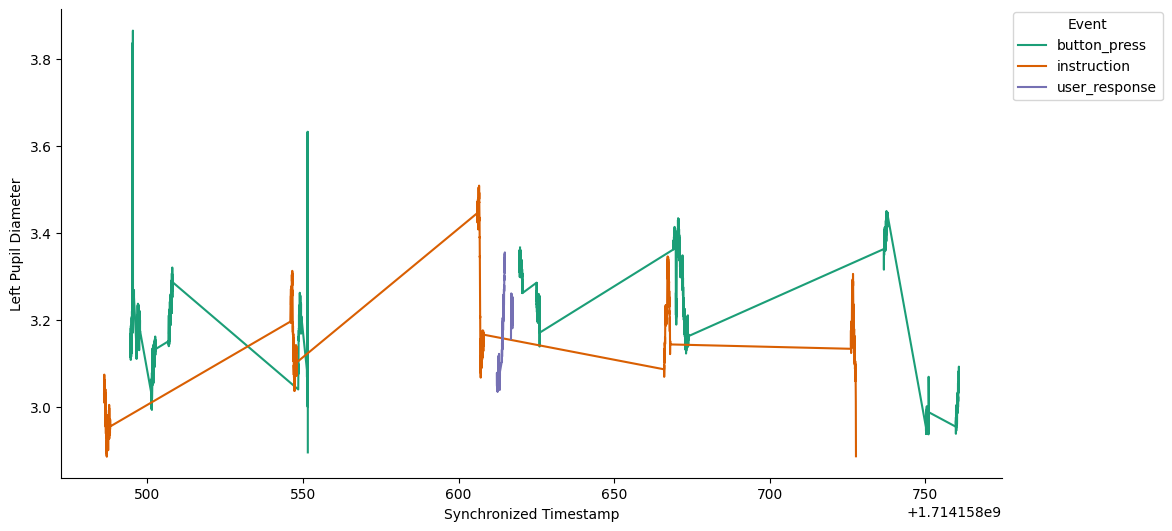

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['synchronized_timestamp']
    ys = series['leftPupilDiameter']
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')

# Identify events of interest
events_of_interest = ['instruction', 'user_response', 'button_press']

# Extract event timestamps
event_timestamps = {}
for event in events_of_interest:
    event_timestamps[event] = python_logger_data[python_logger_data['event_type'] == event]['timestamp'].tolist()

# Align events with eye tracker data
aligned_data = pd.DataFrame()
for event in events_of_interest:
    for timestamp in event_timestamps[event]:
        gaze_data = eye_tracker_data[(eye_tracker_data['synchronized_timestamp'] >= timestamp - 0.5) &
                                     (eye_tracker_data['synchronized_timestamp'] <= timestamp + 0.5)]
        gaze_data['event'] = event
        aligned_data = pd.concat([aligned_data, gaze_data], ignore_index=True)

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = aligned_data.sort_values('synchronized_timestamp', ascending=True)
for i, (event_name, event_data) in enumerate(df_sorted.groupby('event')):
    _plot_series(event_data, event_name, i)

fig.legend(title='Event', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Synchronized Timestamp')
_ = plt.ylabel('Left Pupil Diameter')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
sns.set_theme(rc={'figure.figsize': (10, 8)})

events_of_interest = ['instruction', 'user_response', 'button_press']

# Filter the aligned data for the events of interest
filtered_data = aligned_data[aligned_data['event'].isin(events_of_interest)]

sns.violinplot(x='leftPupilDiameter', y='event', data=filtered_data, palette='Dark2')
plt.xlabel('Left Pupil Diameter')
plt.ylabel('Event Type')
plt.title('Left Pupil Diameter by Event Type')
plt.show()

TypeError: list indices must be integers or slices, not str

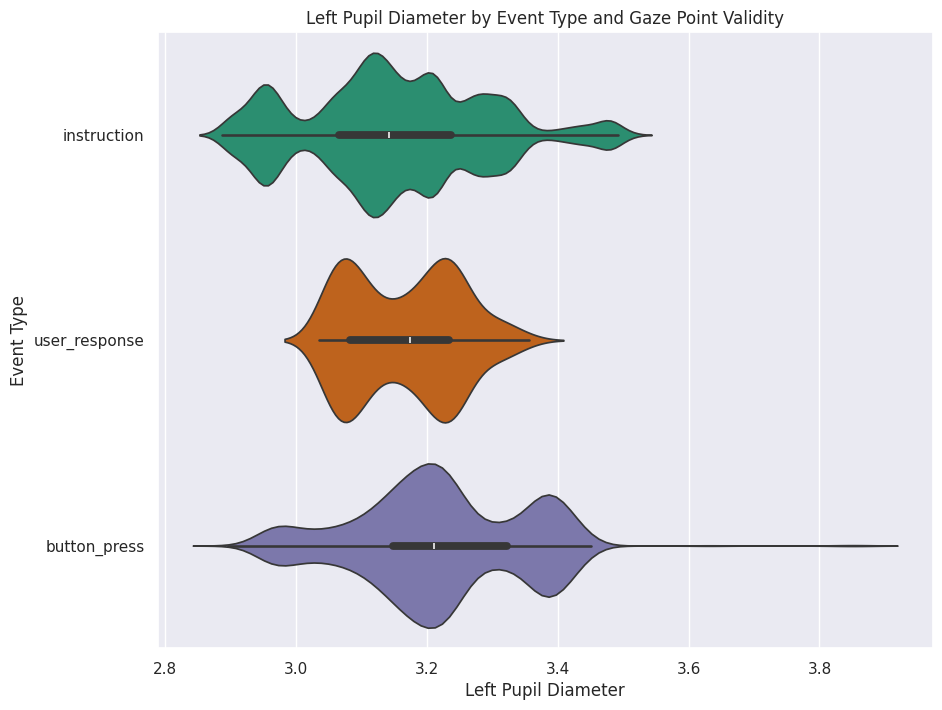

In [ ]:
sns.violinplot(x='leftPupilDiameter', y='event', hue='event', data=filtered_data, palette='Dark2')
plt.xlabel('Left Pupil Diameter')
plt.ylabel('Event Type')
plt.title('Left Pupil Diameter by Event Type and Gaze Point Validity')
plt.show()

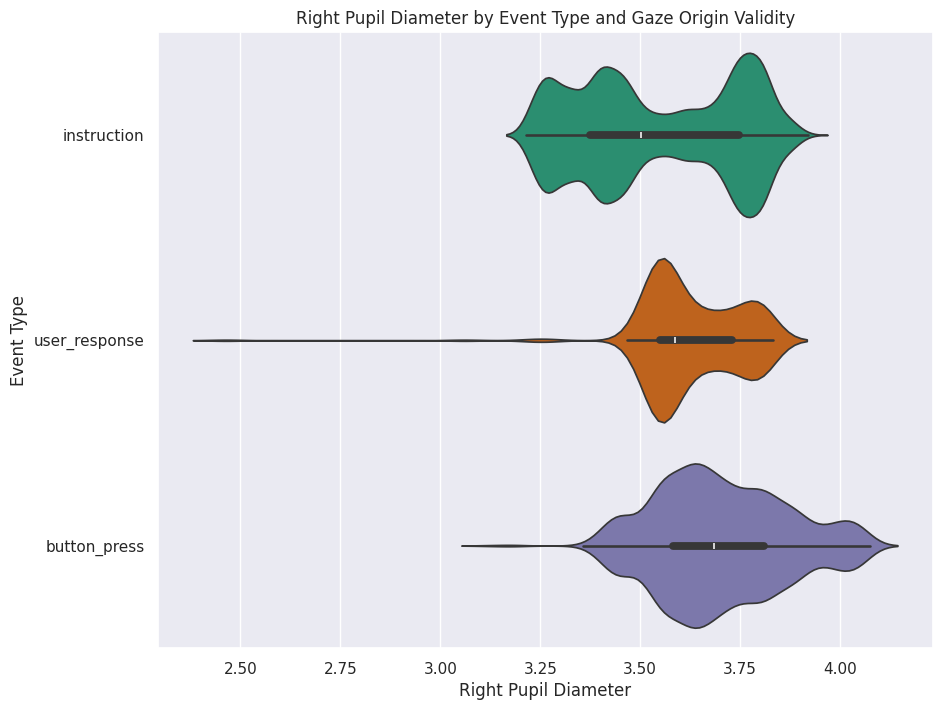

In [ ]:
sns.violinplot(x='rightPupilDiameter', y='event', hue='event', data=filtered_data, palette='Dark2')
plt.xlabel('Right Pupil Diameter')
plt.ylabel('Event Type')
plt.title('Right Pupil Diameter by Event Type and Gaze Origin Validity')
plt.show()

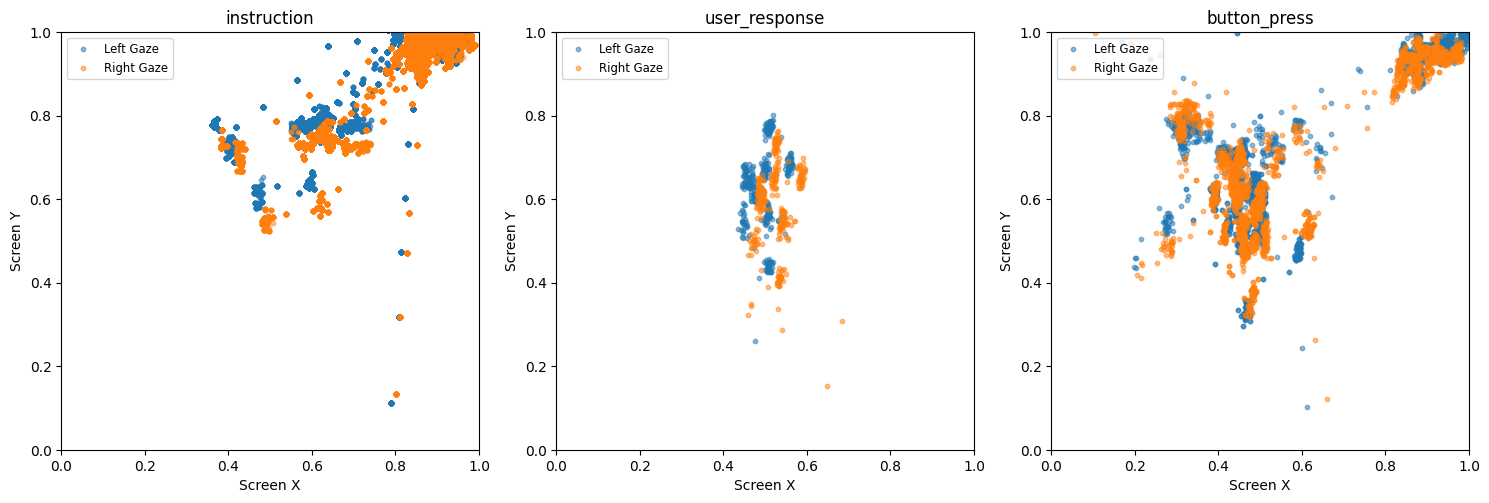

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')

# Identify events of interest
events_of_interest = ['instruction', 'user_response', 'button_press']

# Extract event timestamps
event_timestamps = {}
for event in events_of_interest:
    event_timestamps[event] = python_logger_data.loc[python_logger_data['event_type'] == event, 'timestamp'].tolist()

# Align events with eye tracker data
aligned_data = []
for event in events_of_interest:
    for timestamp in event_timestamps[event]:
        mask = (eye_tracker_data['synchronized_timestamp'] >= timestamp - 0.5) & (eye_tracker_data['synchronized_timestamp'] <= timestamp + 0.5)
        gaze_data = eye_tracker_data.loc[mask].copy()
        gaze_data.loc[:, 'event'] = event
        aligned_data.append(gaze_data)

# Concatenate the aligned data into a single DataFrame
aligned_df = pd.concat(aligned_data, ignore_index=True)

# Print the aligned DataFrame
# print(aligned_df.loc[aligned_df['event']])

# Visualize gaze patterns during events
fig, axes = plt.subplots(1, len(events_of_interest), figsize=(15, 5))

for i, event in enumerate(events_of_interest):
    ax = axes[i]

    event_data = aligned_df.loc[aligned_df['event'] == event]

    left_gaze_x = event_data['leftGazePointDisplay']
    left_gaze_y = event_data['leftGazePointDisplay.1']
    right_gaze_x = event_data['rightGazePointDisplay']
    right_gaze_y = event_data['rightGazePointDisplay.1']

    # Invert y-coordinates
    ax.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, s=10, label='Left Gaze')
    ax.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, s=10, label='Right Gaze')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_title(event)
    ax.set_xlabel('Screen X')
    ax.set_ylabel('Screen Y')

    ax.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

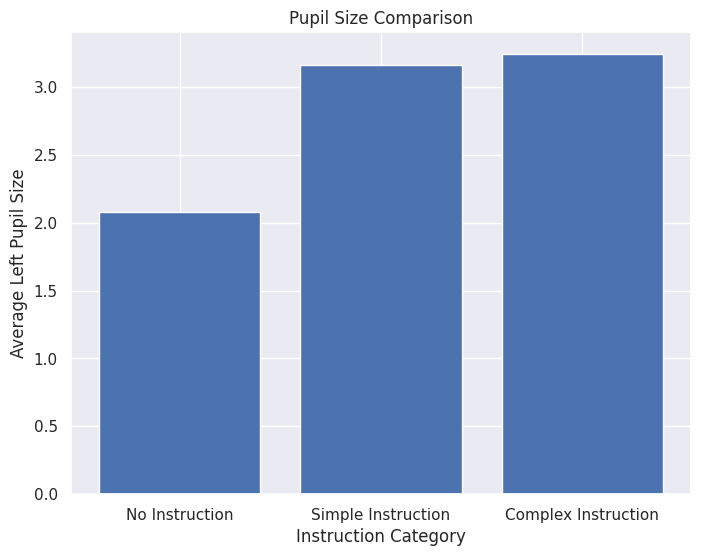

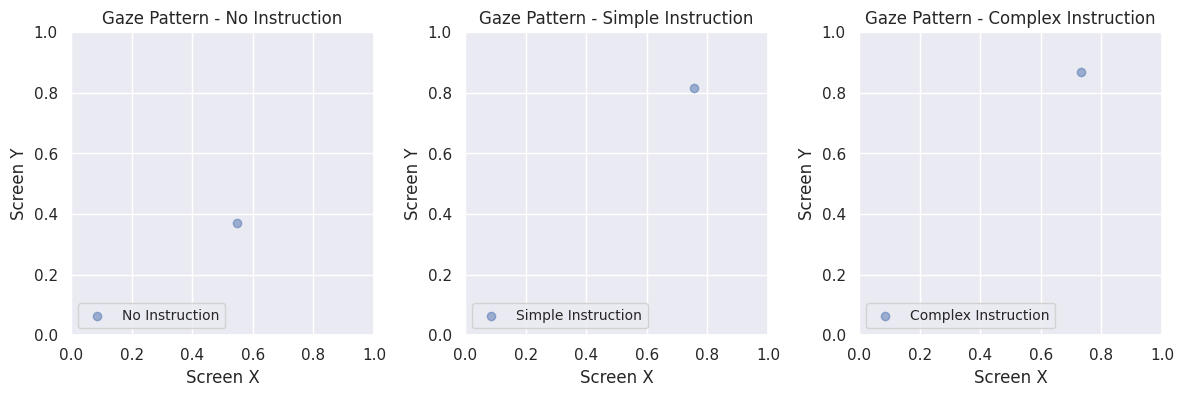

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')

# Categorize instructions into simple and complex
simple_instructions = [
    "Press the right button on D-Pad but turn left at the next intersection.",
    "Press the Square Button on the steering wheel, to check the current speed of the vehicle and press it again to hide",
    "Press the left button on D-Pad but turn right at the next intersection."
]

complex_instructions = [
    "Humans have four lungs. True or False? Press R2 for true and L2 for false on the steering wheel",
    "Adjust AC temperature, to 64 then increase the temparature to 72 and finally set it to 67"
]

# Extract the starting times for each instruction set
instruction_start_times = python_logger_data[python_logger_data['event_type'] == 'instruction']['timestamp'].tolist()

# Analyze pupil size and gaze patterns
def analyze_pupil_size(data, start_time, end_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time) & (data['synchronized_timestamp'] <= end_time)]
    left_pupil_size = filtered_data['leftPupilDiameter'].mean()
    right_pupil_size = filtered_data['rightPupilDiameter'].mean()
    return left_pupil_size, right_pupil_size

def analyze_gaze_pattern(data, start_time, end_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time) & (data['synchronized_timestamp'] <= end_time)]
    left_gaze_x = filtered_data['leftGazePointDisplay'].mean()
    left_gaze_y = filtered_data['leftGazePointDisplay.1'].mean()
    right_gaze_x = filtered_data['rightGazePointDisplay'].mean()
    right_gaze_y = filtered_data['rightGazePointDisplay.1'].mean()
    return left_gaze_x, left_gaze_y, right_gaze_x, right_gaze_y

# Analyze pupil size and gaze patterns for no instruction (first 30 seconds)
no_instruction_start_time = eye_tracker_data['synchronized_timestamp'].min()
no_instruction_end_time = no_instruction_start_time + 30

no_instruction_left_pupil, no_instruction_right_pupil = analyze_pupil_size(eye_tracker_data, no_instruction_start_time, no_instruction_end_time)
no_instruction_left_gaze_x, no_instruction_left_gaze_y, no_instruction_right_gaze_x, no_instruction_right_gaze_y = analyze_gaze_pattern(eye_tracker_data, no_instruction_start_time, no_instruction_end_time)

# Analyze pupil size and gaze patterns for simple instructions
simple_left_pupil_sizes = []
simple_right_pupil_sizes = []
simple_left_gaze_xs = []
simple_left_gaze_ys = []
simple_right_gaze_xs = []
simple_right_gaze_ys = []

for start_time in instruction_start_times:
    instruction = python_logger_data[python_logger_data['timestamp'] == start_time]['instruction'].iloc[0]
    if instruction in simple_instructions:
        end_time = start_time + 5  # Analyze 5 seconds after the instruction starts
        left_pupil, right_pupil = analyze_pupil_size(eye_tracker_data, start_time, end_time)
        left_gaze_x, left_gaze_y, right_gaze_x, right_gaze_y = analyze_gaze_pattern(eye_tracker_data, start_time, end_time)
        simple_left_pupil_sizes.append(left_pupil)
        simple_right_pupil_sizes.append(right_pupil)
        simple_left_gaze_xs.append(left_gaze_x)
        simple_left_gaze_ys.append(left_gaze_y)
        simple_right_gaze_xs.append(right_gaze_x)
        simple_right_gaze_ys.append(right_gaze_y)

# Analyze pupil size and gaze patterns for complex instructions
complex_left_pupil_sizes = []
complex_right_pupil_sizes = []
complex_left_gaze_xs = []
complex_left_gaze_ys = []
complex_right_gaze_xs = []
complex_right_gaze_ys = []

for start_time in instruction_start_times:
    instruction = python_logger_data[python_logger_data['timestamp'] == start_time]['instruction'].iloc[0]
    if instruction in complex_instructions:
        end_time = start_time + 5  # Analyze 5 seconds after the instruction starts
        left_pupil, right_pupil = analyze_pupil_size(eye_tracker_data, start_time, end_time)
        left_gaze_x, left_gaze_y, right_gaze_x, right_gaze_y = analyze_gaze_pattern(eye_tracker_data, start_time, end_time)
        complex_left_pupil_sizes.append(left_pupil)
        complex_right_pupil_sizes.append(right_pupil)
        complex_left_gaze_xs.append(left_gaze_x)
        complex_left_gaze_ys.append(left_gaze_y)
        complex_right_gaze_xs.append(right_gaze_x)
        complex_right_gaze_ys.append(right_gaze_y)

# Visualize pupil size comparison
pupil_sizes = [no_instruction_left_pupil, np.mean(simple_left_pupil_sizes), np.mean(complex_left_pupil_sizes)]
categories = ['No Instruction', 'Simple Instruction', 'Complex Instruction']

plt.figure(figsize=(8, 6))
plt.bar(categories, pupil_sizes)
plt.xlabel('Instruction Category')
plt.ylabel('Average Left Pupil Size')
plt.title('Pupil Size Comparison')
plt.show()

# Visualize gaze patterns
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(no_instruction_left_gaze_x, 1 - no_instruction_left_gaze_y, alpha=0.5, label='No Instruction')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.legend(loc='lower left', fontsize='small')
plt.title('Gaze Pattern - No Instruction')

plt.subplot(1, 3, 2)
plt.scatter(np.mean(simple_left_gaze_xs), 1 - np.mean(simple_left_gaze_ys), alpha=0.5, label='Simple Instruction')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.legend(loc='lower left', fontsize='small')
plt.title('Gaze Pattern - Simple Instruction')

plt.subplot(1, 3, 3)
plt.scatter(np.mean(complex_left_gaze_xs), 1 - np.mean(complex_left_gaze_ys), alpha=0.5, label='Complex Instruction')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.legend(loc='lower left', fontsize='small')
plt.title('Gaze Pattern - Complex Instruction')

plt.tight_layout()
plt.show()

### Old Code, Kept for Reference

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
# eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')
eye_tracker_data = pd.read_excel('Eye Tracker Data.xlsx')


# Categorize instructions into simple and complex
simple_instructions = [
    "Press the right button on D-Pad but turn left at the next intersection.",
    "Press the Square Button on the steering wheel, to check the current speed of the vehicle and press it again to hide",
    "Press the left button on D-Pad but turn right at the next intersection."
]

complex_instructions = [
    "Humans have four lungs. True or False? Press R2 for true and L2 for false on the steering wheel",
    "Adjust AC temperature, to 64 then increase the temparature to 72 and finally set it to 67"
]

# Extract the starting times for each instruction set
instruction_start_times = python_logger_data[python_logger_data['event_type'] == 'instruction']['timestamp'].tolist()

# print(len(instruction_start_times))



299


In [ ]:
# Analyze pupil size and gaze patterns
def analyze_pupil_size(data, start_time, end_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time) & (data['synchronized_timestamp'] <= end_time)]
    left_pupil_size = filtered_data['leftPupilDiameter'].mean()
    right_pupil_size = filtered_data['rightPupilDiameter'].mean()
    return left_pupil_size, right_pupil_size

def analyze_gaze_pattern(data, start_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time - 0.5) & (data['synchronized_timestamp'] <= start_time + 8)]
    return filtered_data

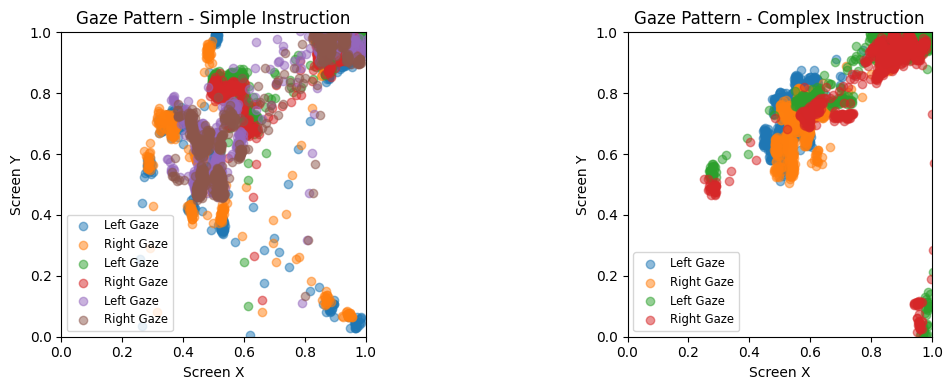

In [ ]:
# Assuming previous steps and data loading are the same...

# Analyze gaze patterns for simple and complex instructions
simple_gaze_data = []
complex_gaze_data = []

last_instruction = ""
for start_time in instruction_start_times:
    instruction = python_logger_data[python_logger_data['timestamp'] == start_time]['instruction'].iloc[0]
    if instruction != last_instruction:
      # print(instruction)
      if instruction in simple_instructions:
          gaze_data = analyze_gaze_pattern(eye_tracker_data, start_time)
          simple_gaze_data.append(gaze_data)
      elif instruction in complex_instructions:
          gaze_data = analyze_gaze_pattern(eye_tracker_data, start_time)
          complex_gaze_data.append(gaze_data)
      last_instruction = instruction


# Visualize gaze patterns
plt.figure(figsize=(12, 4))

# Create flag variables to control legend entry addition
legend_added_simple = False
legend_added_complex = False

# Plotting gaze data for simple instructions
plt.subplot(1, 2, 1)
for gaze_data in simple_gaze_data:
    left_gaze_x = gaze_data['leftGazePointDisplay']
    left_gaze_y = gaze_data['leftGazePointDisplay.1']
    right_gaze_x = gaze_data['rightGazePointDisplay']
    right_gaze_y = gaze_data['rightGazePointDisplay.1']
    plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze' if not legend_added_simple else "")
    plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze' if not legend_added_simple else "")
    legend_added_simple = False
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - Simple Instruction')
plt.legend(loc='lower left', fontsize='small')

# Plotting gaze data for complex instructions
plt.subplot(1, 2, 2)
for gaze_data in complex_gaze_data:
    left_gaze_x = gaze_data['leftGazePointDisplay']
    left_gaze_y = gaze_data['leftGazePointDisplay.1']
    right_gaze_x = gaze_data['rightGazePointDisplay']
    right_gaze_y = gaze_data['rightGazePointDisplay.1']
    plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze' if not legend_added_complex else "")
    plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze' if not legend_added_complex else "")
    legend_added_complex = False
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - Complex Instruction')
plt.legend(loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming previous steps and data loading are the same...

# Define the function to analyze gaze patterns if not already defined
def analyze_gaze_pattern_clean(data, start_time, duration=0.5):
    # Adjust duration to consider a specific window around the start_time
    filtered_data = data[(data['synchronized_timestamp'] >= start_time - duration) & (data['synchronized_timestamp'] <= start_time + duration)]
    return filtered_data
no_instruction_start_time = eye_tracker_data['synchronized_timestamp'].min()

# Extract gaze data for no instruction period
no_instruction_gaze_data = analyze_gaze_pattern_clean(eye_tracker_data, no_instruction_start_time, 30)  # Analyzing the first 15 seconds

# Visualize gaze patterns including no instruction
plt.figure(figsize=(18, 6))

# Set up a subplot for no instruction gaze patterns
plt.subplot(1, 3, 1)
left_gaze_x = no_instruction_gaze_data['leftGazePointDisplay']
left_gaze_y = no_instruction_gaze_data['leftGazePointDisplay.1']
right_gaze_x = no_instruction_gaze_data['rightGazePointDisplay']
right_gaze_y = no_instruction_gaze_data['rightGazePointDisplay.1']
plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze')
plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - No Instruction')
plt.legend(loc='lower left', fontsize='small')

# Plotting gaze data for simple instructions
plt.subplot(1, 3, 2)
for gaze_data in simple_gaze_data:
    left_gaze_x = gaze_data['leftGazePointDisplay']
    left_gaze_y = gaze_data['leftGazePointDisplay.1']
    right_gaze_x = gaze_data['rightGazePointDisplay']
    right_gaze_y = gaze_data['rightGazePointDisplay.1']
    plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze' if left_gaze_x.empty else "")
    plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze' if right_gaze_x.empty else "")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - Simple Instruction')
plt.legend(loc='lower left', fontsize='small')

# Plotting gaze data for complex instructions
plt.subplot(1, 3, 3)
for gaze_data in complex_gaze_data:
    left_gaze_x = gaze_data['leftGazePointDisplay']
    left_gaze_y = gaze_data['leftGazePointDisplay.1']
    right_gaze_x = gaze_data['rightGazePointDisplay']
    right_gaze_y = gaze_data['rightGazePointDisplay.1']
    plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze' if left_gaze_x.empty else "")
    plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze' if right_gaze_x.empty else "")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - Complex Instruction')
plt.legend(loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()


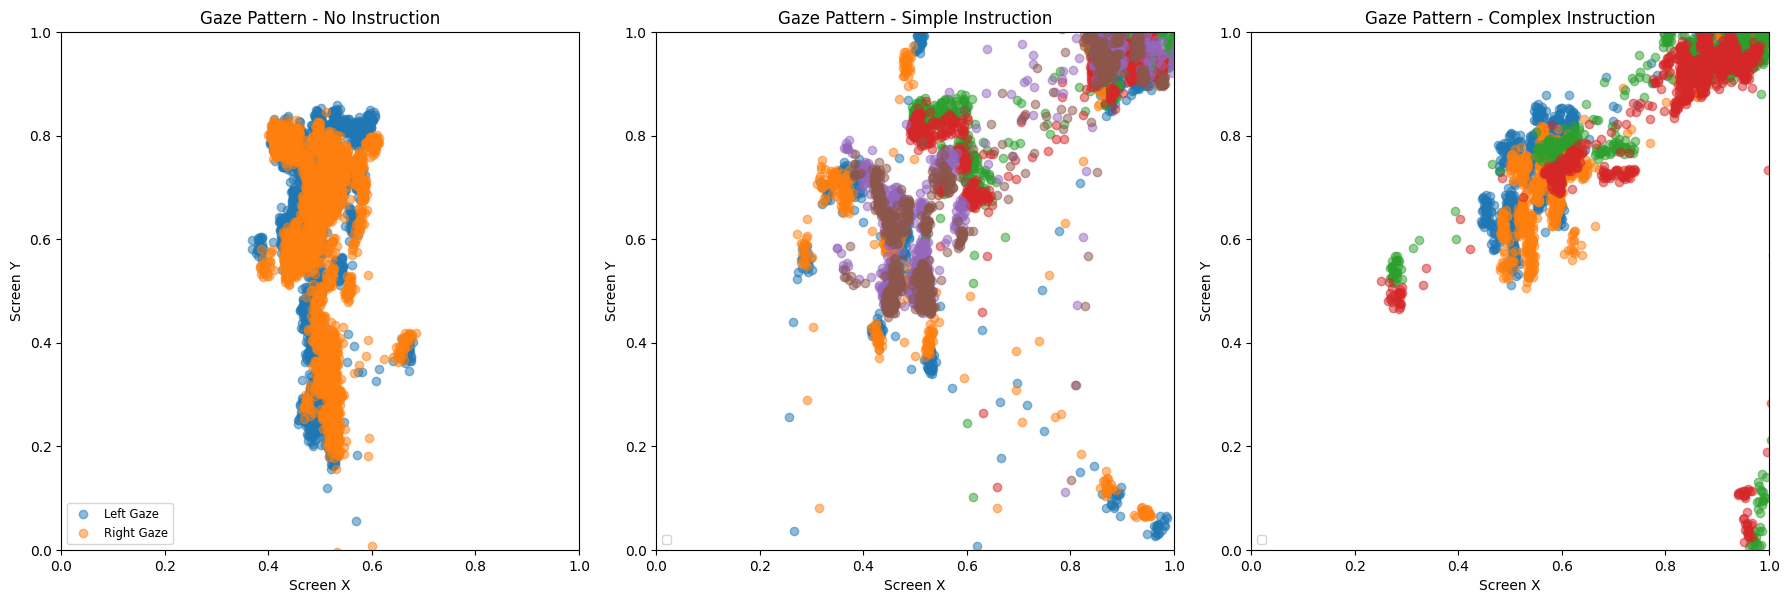

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
# eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')
eye_tracker_data = pd.read_excel('Eye Tracker Data.xlsx')


# Categorize instructions into simple and complex
simple_instructions = [
    "Press the right button on D-Pad but turn left at the next intersection.",
    "Press the Square Button on the steering wheel, to check the current speed of the vehicle and press it again to hide",
    "Press the left button on D-Pad but turn right at the next intersection."
]

complex_instructions = [
    "Humans have four lungs. True or False? Press R2 for true and L2 for false on the steering wheel",
    "Adjust AC temperature, to 64 then increase the temparature to 72 and finally set it to 67"
]

# Extract the starting times for each instruction set
instruction_start_times = python_logger_data[python_logger_data['event_type'] == 'instruction']['timestamp'].tolist()





# Analyze pupil size and gaze patterns
def analyze_pupil_size(data, start_time, end_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time) & (data['synchronized_timestamp'] <= end_time)]
    left_pupil_size = filtered_data['leftPupilDiameter'].mean()
    right_pupil_size = filtered_data['rightPupilDiameter'].mean()
    return left_pupil_size, right_pupil_size

def analyze_gaze_pattern(data, start_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time - 0.5) & (data['synchronized_timestamp'] <= start_time + 8)]
    return filtered_data






# Analyze gaze patterns for simple and complex instructions
simple_gaze_data = []
complex_gaze_data = []

last_instruction = ""
for start_time in instruction_start_times:
    instruction = python_logger_data[python_logger_data['timestamp'] == start_time]['instruction'].iloc[0]
    if instruction != last_instruction:
      # print(instruction)
      if instruction in simple_instructions:
          gaze_data = analyze_gaze_pattern(eye_tracker_data, start_time)
          simple_gaze_data.append(gaze_data)
      elif instruction in complex_instructions:
          gaze_data = analyze_gaze_pattern(eye_tracker_data, start_time)
          complex_gaze_data.append(gaze_data)
      last_instruction = instruction









# Define the function to analyze gaze patterns if not already defined
def analyze_gaze_pattern_clean(data, start_time, duration=0.5):
    # Adjust duration to consider a specific window around the start_time
    filtered_data = data[(data['synchronized_timestamp'] >= start_time - duration) & (data['synchronized_timestamp'] <= start_time + duration)]
    return filtered_data
no_instruction_start_time = eye_tracker_data['synchronized_timestamp'].min()

# Extract gaze data for no instruction period
no_instruction_gaze_data = analyze_gaze_pattern_clean(eye_tracker_data, no_instruction_start_time, 30)  # Analyzing the first 15 seconds







# Visualize gaze patterns including no instruction
plt.figure(figsize=(18, 6))

# Set up a subplot for no instruction gaze patterns
plt.subplot(1, 3, 1)
left_gaze_x = no_instruction_gaze_data['leftGazePointDisplay']
left_gaze_y = no_instruction_gaze_data['leftGazePointDisplay.1']
right_gaze_x = no_instruction_gaze_data['rightGazePointDisplay']
right_gaze_y = no_instruction_gaze_data['rightGazePointDisplay.1']
plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze')
plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - No Instruction')
plt.legend(loc='lower left', fontsize='small')

# Plotting gaze data for simple instructions
plt.subplot(1, 3, 2)
for gaze_data in simple_gaze_data:
    left_gaze_x = gaze_data['leftGazePointDisplay']
    left_gaze_y = gaze_data['leftGazePointDisplay.1']
    right_gaze_x = gaze_data['rightGazePointDisplay']
    right_gaze_y = gaze_data['rightGazePointDisplay.1']
    plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze' if left_gaze_x.empty else "")
    plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze' if right_gaze_x.empty else "")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - Simple Instruction')
plt.legend(loc='lower left', fontsize='small')

# Plotting gaze data for complex instructions
plt.subplot(1, 3, 3)
for gaze_data in complex_gaze_data:
    left_gaze_x = gaze_data['leftGazePointDisplay']
    left_gaze_y = gaze_data['leftGazePointDisplay.1']
    right_gaze_x = gaze_data['rightGazePointDisplay']
    right_gaze_y = gaze_data['rightGazePointDisplay.1']
    plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, label='Left Gaze' if left_gaze_x.empty else "")
    plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, label='Right Gaze' if right_gaze_x.empty else "")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Screen X')
plt.ylabel('Screen Y')
plt.title('Gaze Pattern - Complex Instruction')
plt.legend(loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()

### **Gaze Pattern Analysis**

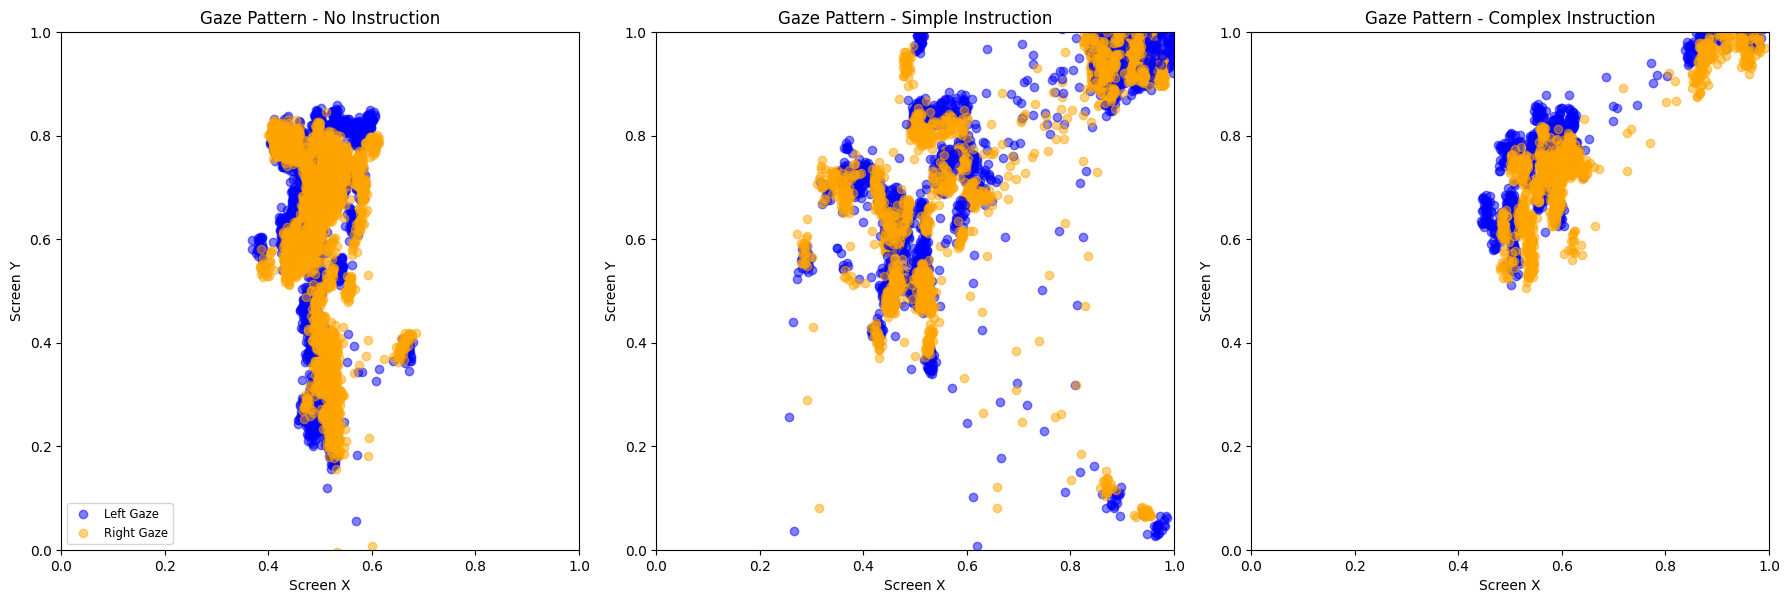

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
eye_tracker_data = pd.read_excel('Eye Tracker Data.xlsx')

# Categorize instructions into simple and complex
simple_instructions = [
    "Press the right button on D-Pad but turn left at the next intersection.",
    "Press the Square Button on the steering wheel, to check the current speed of the vehicle and press it again to hide",
    "Press the left button on D-Pad but turn right at the next intersection."
]

complex_instructions = [
    "Humans have four lungs. True or False? Press R2 for true and L2 for false on the steering wheel",
    "Adjust AC temperature, to 64 then increase the temperature to 72 and finally set it to 67"
]

# Extract the starting times for each instruction set
instruction_start_times = python_logger_data[python_logger_data['event_type'] == 'instruction']['timestamp'].tolist()

# Define the function to analyze gaze patterns
def analyze_gaze_pattern(data, start_time, duration=8):  # I've adjusted this for a standard call
    filtered_data = data[(data['synchronized_timestamp'] >= start_time - 0.5) & (data['synchronized_timestamp'] <= start_time + duration)]
    return filtered_data

# Define the function to analyze gaze patterns for the no instruction period
def analyze_gaze_pattern_clean(data, start_time, duration=30):  # For no instruction, using 30 seconds
    filtered_data = data[(data['synchronized_timestamp'] >= start_time) & (data['synchronized_timestamp'] <= start_time + duration)]
    return filtered_data

# Extract gaze data for no instruction period
no_instruction_start_time = eye_tracker_data['synchronized_timestamp'].min()
no_instruction_gaze_data = analyze_gaze_pattern_clean(eye_tracker_data, no_instruction_start_time, 30)

# Analyze gaze patterns for simple and complex instructions
simple_gaze_data = []
complex_gaze_data = []

last_instruction = ""
for start_time in instruction_start_times:
    instruction = python_logger_data[python_logger_data['timestamp'] == start_time]['instruction'].iloc[0]
    if instruction != last_instruction:
        if instruction in simple_instructions:
            gaze_data = analyze_gaze_pattern(eye_tracker_data, start_time)
            simple_gaze_data.append(gaze_data)
        elif instruction in complex_instructions:
            gaze_data = analyze_gaze_pattern(eye_tracker_data, start_time)
            complex_gaze_data.append(gaze_data)
        last_instruction = instruction

# Visualize gaze patterns including no instruction
plt.figure(figsize=(18, 6))

# Function to plot gaze data, handling colors and legends consistently
def plot_gaze_data(gaze_data, subplot_index, title):
    plt.subplot(1, 3, subplot_index)
    for data in gaze_data:
        left_gaze_x = data['leftGazePointDisplay']
        left_gaze_y = data['leftGazePointDisplay.1']
        right_gaze_x = data['rightGazePointDisplay']
        right_gaze_y = data['rightGazePointDisplay.1']
        plt.scatter(left_gaze_x, 1 - left_gaze_y, alpha=0.5, color='blue', label='Left Gaze')
        plt.scatter(right_gaze_x, 1 - right_gaze_y, alpha=0.5, color='orange', label='Right Gaze')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Screen X')
    plt.ylabel('Screen Y')
    plt.title(title)
    if subplot_index == 1:  # Only add legend in the first plot
        plt.legend(loc='lower left', fontsize='small')

# Plotting all gaze data
plot_gaze_data([no_instruction_gaze_data], 1, 'Gaze Pattern - No Instruction')
plot_gaze_data(simple_gaze_data, 2, 'Gaze Pattern - Simple Instruction')
plot_gaze_data(complex_gaze_data, 3, 'Gaze Pattern - Complex Instruction')

plt.tight_layout()
plt.show()


### **Pupil Dilation Analysis**

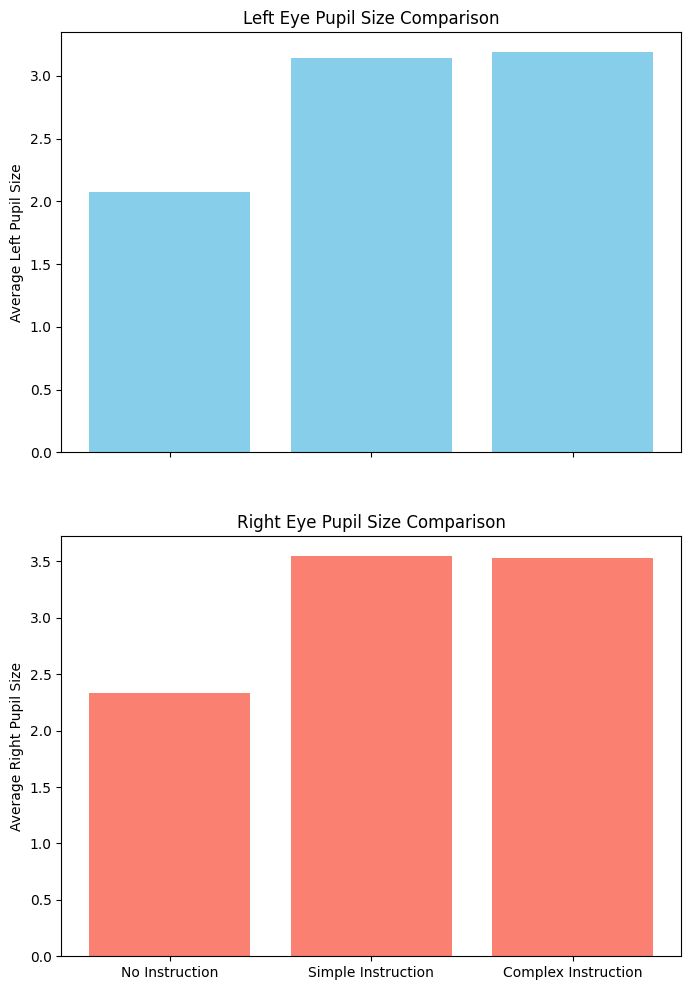

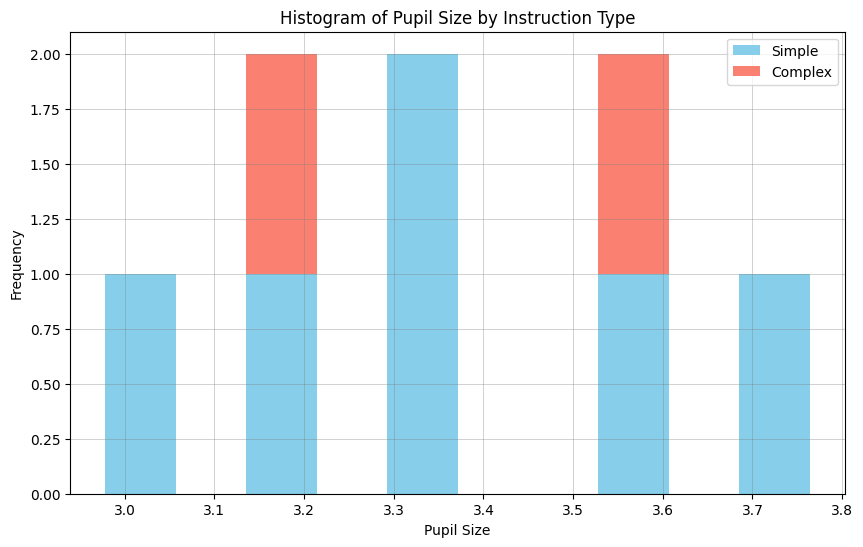

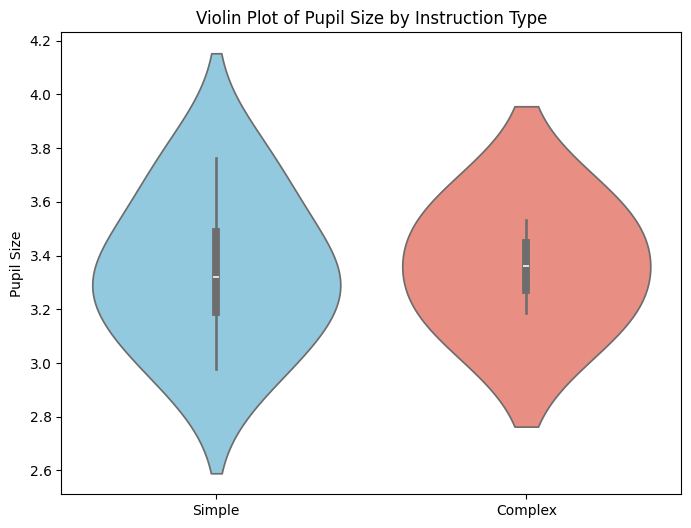

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the cleaned Python logger data
python_logger_data = pd.read_csv('cleaned_python_logger_data.csv')

# Load the synchronized eye tracker data
eye_tracker_data = pd.read_excel('synchronized_eye_tracker_data.xlsx')

# Define instruction categories
simple_instructions = [
    "Press the right button on D-Pad but turn left at the next intersection.",
    "Press the Square Button on the steering wheel, to check the current speed of the vehicle and press it again to hide",
    "Press the left button on D-Pad but turn right at the next intersection."
]

complex_instructions = [
    "Humans have four lungs. True or False? Press R2 for true and L2 for false on the steering wheel",
    "Adjust AC temperature, to 64 then increase the temperature to 72 and finally set it to 67"
]

# Function to analyze pupil size
def analyze_pupil_size(data, start_time, end_time):
    filtered_data = data[(data['synchronized_timestamp'] >= start_time) & (data['synchronized_timestamp'] <= end_time)]
    left_pupil_size = filtered_data['leftPupilDiameter'].mean()
    right_pupil_size = filtered_data['rightPupilDiameter'].mean()
    return left_pupil_size, right_pupil_size

# Collect pupil sizes for different instruction types
instruction_start_times = python_logger_data[python_logger_data['event_type'] == 'instruction']['timestamp'].tolist()
no_instruction_start_time = eye_tracker_data['synchronized_timestamp'].min()
no_instruction_end_time = no_instruction_start_time + 30

# No instruction pupil sizes
no_instruction_left_pupil, no_instruction_right_pupil = analyze_pupil_size(eye_tracker_data, no_instruction_start_time, no_instruction_end_time)

# Instruction pupil sizes
simple_left_pupil_sizes = []
simple_right_pupil_sizes = []
complex_left_pupil_sizes = []
complex_right_pupil_sizes = []
last_instruction = ""

for start_time in instruction_start_times:
    instruction = python_logger_data[python_logger_data['timestamp'] == start_time]['instruction'].iloc[0]
    if instruction != last_instruction:
        end_time = start_time + 5  # Analyze 5 seconds after the instruction starts
        left_pupil, right_pupil = analyze_pupil_size(eye_tracker_data, start_time, end_time)
        if instruction in simple_instructions:
            simple_left_pupil_sizes.append(left_pupil)
            simple_right_pupil_sizes.append(right_pupil)
        elif instruction in complex_instructions:
            complex_left_pupil_sizes.append(left_pupil)
            complex_right_pupil_sizes.append(right_pupil)
        last_instruction = instruction

# Bar chart for average pupil size
fig, axs = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
categories = ['No Instruction', 'Simple Instruction', 'Complex Instruction']
left_pupil_sizes = [no_instruction_left_pupil, np.mean(simple_left_pupil_sizes), np.mean(complex_left_pupil_sizes)]
right_pupil_sizes = [no_instruction_right_pupil, np.mean(simple_right_pupil_sizes), np.mean(complex_right_pupil_sizes)]

axs[0].bar(categories, left_pupil_sizes, color='skyblue')
axs[0].set_ylabel('Average Left Pupil Size')
axs[0].set_title('Left Eye Pupil Size Comparison')


axs[1].bar(categories, right_pupil_sizes, color='salmon')
axs[1].set_ylabel('Average Right Pupil Size')
axs[1].set_title('Right Eye Pupil Size Comparison')
plt.show()

# Combined histogram for both eyes
plt.figure(figsize=(10, 6))
plt.hist([simple_left_pupil_sizes + simple_right_pupil_sizes, complex_left_pupil_sizes + complex_right_pupil_sizes], bins=10, color=['skyblue', 'salmon'], stacked=True, label=['Simple', 'Complex'])
plt.xlabel('Pupil Size')
plt.ylabel('Frequency')
plt.title('Histogram of Pupil Size by Instruction Type')
plt.legend()
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

# Combined violin plot for both eyes
combined_data = [simple_left_pupil_sizes + simple_right_pupil_sizes, complex_left_pupil_sizes + complex_right_pupil_sizes]
plt.figure(figsize=(8, 6))
sns.violinplot(data=combined_data, palette=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Simple', 'Complex'])
plt.ylabel('Pupil Size')
plt.title('Violin Plot of Pupil Size by Instruction Type')
# plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.show()
